In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
VER = 5

# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = f'VER_{VER}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='FB3'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=20
    num_workers=0
    # Suggest: Rostlab/prot_bert or ESMs at https://huggingface.co/models?sort=downloads&search=esm
    # ESM examples: facebook/esm2_t33_650M_UR50D, facebook/esm1v_t33_650M_UR90S_1, facebook/esm1b_t33_650M_UR50S, etc 
    model="facebook/esm2_t33_650M_UR50D" 
    gradient_checkpointing=False
    scheduler='constant' # ['linear', 'cosine', 'constant']
    batch_scheduler=True
    num_warmup_steps=0
    
    # LEARNING RATE
    # Suggested for batchsize=8: Prot_bert = 5e-6, ESM2 = 5e-5
    epochs=1
    num_cycles=1.0 #only affects cosine schedule
    encoder_lr=5e-5
    decoder_lr=5e-5
    batch_size=8
        # MODEL INFO - PROT_BERT
    total_blocks = 30 
    initial_layers = 5 
    layers_per_block = 16 
    # MODEL INFO - FACEBOOK ESM2
    if 'esm2' in model:
        total_blocks = int(model.split('_')[1][1:])
        initial_layers = 2 
        layers_per_block = 16 
        print('esm2 detected')
    # MODEL INFO - FACEBOOK ESM1B
    elif 'esm1b' in model:
        total_blocks = int(model.split('_')[1][1:])
        initial_layers = 4 
        layers_per_block = 16 
        print('esm1b detected')
    # MODEL INFO - FACEBOOK ESM1V
    elif 'esm1v' in model:
        total_blocks = int(model.split('_')[1][1:])
        initial_layers = 2 
        layers_per_block = 16 
        print('esm1v detected')
    else:
        print('prot_bert detected')
        
    # FREEZE
    # Suggested: Prot_bert -8, ESM2 -3
    num_freeze_blocks = total_blocks - 3
    
    # FOR NO FREEZE USE
    #num_freeze_blocks = 0

    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_cols=['target']
    seed=42
    n_fold=4
    trn_fold=[0,1,2,3]
    train=True
    pca_dim = 64
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

esm2 detected


In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='FB3-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
#os.system('pip install iterative-stratification==0.1.7')
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

#os.system('pip uninstall -y transformers')
#os.system('pip uninstall -y tokenizers')
#os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels transformers')
#os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels tokenizers')
os.system('pip install transformers --upgrade')
#os.system('pip install tokenizers --upgrade')

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import get_constant_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizers.__version__: 0.13.2
transformers.__version__: 4.25.1
env: TOKENIZERS_PARALLELISM=true


In [9]:
# ====================================================
# Utils
# ====================================================
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    return logger

LOGGER = get_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [10]:
train = pd.read_csv('/content/drive/Shareddrives/Erdos Team Pine/Kaggle Dataset - Functioning Code/input/all_train_data.csv')
train = train.loc[train.source.str.contains('jin')]
print('Train has shape:', train.shape )
train.head()

Train has shape: (5072, 10)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1A5E,L,121,R,0.66,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN
1,1A5E,L,37,S,0.71,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGASPNAPNSYGR...,jin_train.csv,NaN,NaN
2,1A5E,W,15,D,0.17,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADDLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN
3,1A5E,D,74,N,-2.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN
4,1A5E,P,81,L,0.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,NaN


In [11]:
def add_spaces(x):
    return " ".join(list(x))
train.sequence = train.sequence.map(add_spaces)
train.mutant_seq = train.mutant_seq.map(add_spaces)
print('Train has shape',train.shape)
train.head()

Train has shape (5072, 10)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1A5E,L,121,R,0.66,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN
1,1A5E,L,37,S,0.71,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN
2,1A5E,W,15,D,0.17,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D D L A T A A A R G ...,jin_train.csv,NaN,NaN
3,1A5E,D,74,N,-2.00,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN
4,1A5E,P,81,L,0.00,M E P A A G S S M E P S A D W L A T A A A R G ...,M E P A A G S S M E P S A D W L A T A A A R G ...,jin_train.csv,NaN,NaN


In [12]:
REMOVE_CT = 20
train['n'] = train.groupby('PDB').PDB.transform('count')
train = train.loc[train.n>REMOVE_CT]
print(f'After removing mutation groups with less than {REMOVE_CT} mutations, our data has shape:')
print( train.shape )

After removing mutation groups with less than 20 mutations, our data has shape:
(4085, 11)


In [13]:
len(train.loc[train.wildtype.isin(['L','W','P','D'])])

751

In [14]:
ho_nlp = train.loc[train.wildtype.isin(['L','W','P','D'])]

In [15]:
train = train.loc[~train.wildtype.isin(['L','W','P','D'])]

In [16]:
print(len(ho_nlp))
print(len(train))

751
3334


In [17]:
# RANK NORMALIZE EACH GROUP OF MUTATION PROTEINS
from scipy.stats import rankdata
train['target'] = 0.5
for p in train.PDB.unique():
    target = 'dTm'
    tmp = train.loc[train.PDB==p,'dTm']
    if tmp.isna().sum()>len(tmp)/2: target = 'ddG'
    train.loc[train.PDB==p,'target'] =\
        rankdata( train.loc[train.PDB==p,target] )/len( train.loc[train.PDB==p,target] )
train = train.reset_index(drop=True)

In [18]:
print('Our train data has',train.PDB.nunique(),'unique mutation groups')

Our train data has 60 unique mutation groups


In [19]:
from sklearn.model_selection import GroupKFold

In [20]:
# ====================================================
# CV split
# ====================================================
Fold = GroupKFold(n_splits=CFG.n_fold) 
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_cols], train.PDB)):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    837
1    836
2    824
3    837
dtype: int64

In [21]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

In [22]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [23]:
tokenizer

PreTrainedTokenizer(name_or_path='facebook/esm2_t33_650M_UR50D', vocab_size=33, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>'})

In [24]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=cfg.max_len,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts1 = df['sequence'].values
        self.texts2 = df['mutant_seq'].values
        self.labels = df[cfg.target_cols].values
        self.position = df['position'].values

    def __len__(self):
        return len(self.texts1)

    def __getitem__(self, item):
        inputs1 = prepare_input(self.cfg, self.texts1[item])
        inputs2 = prepare_input(self.cfg, self.texts2[item])
        position = np.zeros(self.cfg.max_len)
        position[self.position[item]] = 1
        position = torch.tensor(position, dtype=torch.int)
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs1, inputs2, position, label
    

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

In [25]:
fake = pd.DataFrame(columns=['sequence','mutant_seq','position','target'])
fake['sequence'] = ['V P V N P E','V P V N P E']
fake['mutant_seq'] = ['V P A N P E','V P V N P C']
fake['position'] = [3,6]
fake['target'] = [0.2,0.8]
fake.head()

,sequence,mutant_seq,position,target
0,V P V N P E,V P A N P E,3,0.2
1,V P V N P E,V P V N P C,6,0.8


In [26]:
class CFG_fake:
    max_len = 8
    target_cols = ['target']
    tokenizer = CFG.tokenizer
    
train_dataset = TrainDataset(CFG_fake, fake)
train_loader = DataLoader(train_dataset,
                          batch_size=2,
                          shuffle=False)
for inputs1,inputs2,position,label in train_loader:
    break
    
print('Inputs1 =')
print(inputs1,'\n')
print('Inputs2 =')
print(inputs2,'\n')
print('Position =')
print(position,'\n')
print('Label =')
print(label)

Inputs1 =
{'input_ids': tensor([[ 0,  7, 14,  7, 17, 14,  9,  2],
        [ 0,  7, 14,  7, 17, 14,  9,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])} 

Inputs2 =
{'input_ids': tensor([[ 0,  7, 14,  5, 17, 14,  9,  2],
        [ 0,  7, 14,  7, 17, 14, 23,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])} 

Position =
tensor([[0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0]], dtype=torch.int32) 

Label =
tensor([[0.2000],
        [0.8000]])


In [27]:
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
            #self.config = AutoConfig.from_pretrained(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
            
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()
        self.pool = MeanPooling()
        self.fc1 = nn.Linear(self.config.hidden_size, self.cfg.pca_dim)
        self.fc2 = nn.Linear(self.cfg.pca_dim*6, 1)
        self._init_weights(self.fc1)
        self._init_weights(self.fc2)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs, position):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, position)
        return feature

    def forward(self, inputs1, inputs2, position):
        feature1 = self.fc1(self.feature(inputs1, position))
        feature2 = self.fc1(self.feature(inputs2, position))
        
        feature3 = self.fc1(self.feature(inputs1, inputs1['attention_mask']))
        feature4 = self.fc1(self.feature(inputs2, inputs2['attention_mask']))        
        
        feature = torch.cat((feature1, feature2, feature2 - feature1,
                             feature3, feature4, feature4 - feature3),axis=-1)

        output = self.fc2(feature)
        return output

In [28]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, reduction='mean', eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.reduction = reduction
        self.eps = eps

    def forward(self, y_pred, y_true):
        loss = torch.sqrt(self.mse(y_pred, y_true) + self.eps)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss

In [29]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs1, inputs2, position, labels) in enumerate(train_loader):
        #inputs1 = collate(inputs1)
        for k, v in inputs1.items():
            inputs1[k] = v.to(device)
        #inputs2 = collate(inputs2)
        for k, v in inputs2.items():
            inputs2[k] = v.to(device)
        position = position.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs1,inputs2,position)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs1, inputs2, position, labels) in enumerate(valid_loader):
        #inputs = collate(inputs)
        for k, v in inputs1.items():
            inputs1[k] = v.to(device)
        for k, v in inputs2.items():
            inputs2[k] = v.to(device)
        position = position.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs1,inputs2,position)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


In [30]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values
    print('### train shape:',train_folds.shape)
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    
    # FREEZE LAYERS
    if CFG.num_freeze_blocks>0:
        print(f'### Freezing first {CFG.num_freeze_blocks} blocks.',
              f'Leaving {CFG.total_blocks-CFG.num_freeze_blocks} blocks unfrozen')
        for name, param in list(model.named_parameters())\
            [:CFG.initial_layers+CFG.layers_per_block*CFG.num_freeze_blocks]:     
                param.requires_grad = False
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters
    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'constant':
            scheduler = get_constant_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = RMSELoss(reduction="mean") #nn.SmoothL1Loss(reduction='mean')
    
    best_score = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score, scores = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {scores}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score > score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [31]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df[CFG.target_cols].values
        preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {scores}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

INFO:__main__:========== fold: 0 training ==========


### train shape: (2497, 13)


Downloading:   0%|          | 0.00/724 [00:00<?, ?B/s]

INFO:__main__:EsmConfig {
  "_name_or_path": "facebook/esm2_t33_650M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1280,
  "initializer_range": 0.02,
  "intermediate_size": 5120,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 33,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}



Downloading:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['esm.contact_head.regression.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'esm.contact_head.regression.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this mode

### Freezing first 30 blocks. Leaving 3 blocks unfrozen
Epoch: [1][0/312] Elapsed 0m 4s (remain 25m 36s) Loss: 0.4747(0.4747) Grad: inf  LR: 0.00005000  
Epoch: [1][20/312] Elapsed 1m 3s (remain 14m 39s) Loss: 0.2744(0.4202) Grad: 80078.2812  LR: 0.00005000  
Epoch: [1][40/312] Elapsed 2m 8s (remain 14m 7s) Loss: 0.2875(0.3686) Grad: 63400.5156  LR: 0.00005000  
Epoch: [1][60/312] Elapsed 3m 12s (remain 13m 11s) Loss: 0.2511(0.3315) Grad: 80653.8438  LR: 0.00005000  
Epoch: [1][80/312] Elapsed 4m 16s (remain 12m 11s) Loss: 0.3879(0.3170) Grad: 101330.0469  LR: 0.00005000  
Epoch: [1][100/312] Elapsed 5m 20s (remain 11m 10s) Loss: 0.2680(0.3034) Grad: 38698.2539  LR: 0.00005000  
Epoch: [1][120/312] Elapsed 6m 25s (remain 10m 8s) Loss: 0.2060(0.2934) Grad: 34441.1836  LR: 0.00005000  
Epoch: [1][140/312] Elapsed 7m 29s (remain 9m 5s) Loss: 0.1728(0.2863) Grad: 146367.0469  LR: 0.00005000  
Epoch: [1][160/312] Elapsed 8m 34s (remain 8m 2s) Loss: 0.2403(0.2813) Grad: 30365.5059  LR: 0.000

INFO:__main__:Epoch 1 - avg_train_loss: 0.2530  avg_val_loss: 0.2178  time: 1838s
INFO:__main__:Epoch 1 - Score: 0.2562  Scores: [0.2562316641516275]
INFO:__main__:Epoch 1 - Save Best Score: 0.2562 Model


EVAL: [52/53] Elapsed 13m 59s (remain 0m 0s) Loss: 0.2533(0.2178) 


INFO:__main__:========== fold: 0 result ==========
INFO:__main__:Score: 0.2562  Scores: [0.2562316641516275]
INFO:__main__:========== fold: 1 training ==========


### train shape: (2498, 13)


INFO:__main__:EsmConfig {
  "_name_or_path": "facebook/esm2_t33_650M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1280,
  "initializer_range": 0.02,
  "intermediate_size": 5120,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 33,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['esm.con

### Freezing first 30 blocks. Leaving 3 blocks unfrozen
Epoch: [1][0/312] Elapsed 0m 3s (remain 16m 2s) Loss: 0.4963(0.4963) Grad: 164524.2344  LR: 0.00005000  
Epoch: [1][20/312] Elapsed 1m 8s (remain 15m 44s) Loss: 0.1578(0.3574) Grad: 43719.1797  LR: 0.00005000  
Epoch: [1][40/312] Elapsed 2m 12s (remain 14m 36s) Loss: 0.3281(0.3344) Grad: 45532.9766  LR: 0.00005000  
Epoch: [1][60/312] Elapsed 3m 16s (remain 13m 29s) Loss: 0.2649(0.3140) Grad: 34748.5234  LR: 0.00005000  
Epoch: [1][80/312] Elapsed 4m 20s (remain 12m 23s) Loss: 0.1873(0.2971) Grad: 28052.2656  LR: 0.00005000  
Epoch: [1][100/312] Elapsed 5m 25s (remain 11m 19s) Loss: 0.1623(0.2827) Grad: 106855.7891  LR: 0.00005000  
Epoch: [1][120/312] Elapsed 6m 29s (remain 10m 14s) Loss: 0.2683(0.2753) Grad: 50615.2227  LR: 0.00005000  
Epoch: [1][140/312] Elapsed 7m 33s (remain 9m 10s) Loss: 0.2024(0.2709) Grad: 26805.9727  LR: 0.00005000  
Epoch: [1][160/312] Elapsed 8m 37s (remain 8m 5s) Loss: 0.2728(0.2657) Grad: 46300.0430 

INFO:__main__:Epoch 1 - avg_train_loss: 0.2465  avg_val_loss: 0.2250  time: 1844s
INFO:__main__:Epoch 1 - Score: 0.2677  Scores: [0.26765072656214517]
INFO:__main__:Epoch 1 - Save Best Score: 0.2677 Model


EVAL: [52/53] Elapsed 13m 59s (remain 0m 0s) Loss: 0.4402(0.2250) 


INFO:__main__:========== fold: 1 result ==========
INFO:__main__:Score: 0.2677  Scores: [0.26765072656214517]
INFO:__main__:========== fold: 2 training ==========


### train shape: (2510, 13)


INFO:__main__:EsmConfig {
  "_name_or_path": "facebook/esm2_t33_650M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1280,
  "initializer_range": 0.02,
  "intermediate_size": 5120,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 33,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['esm.con

### Freezing first 30 blocks. Leaving 3 blocks unfrozen
Epoch: [1][0/313] Elapsed 0m 3s (remain 16m 7s) Loss: 0.3666(0.3666) Grad: 126581.0469  LR: 0.00005000  
Epoch: [1][20/313] Elapsed 1m 7s (remain 15m 42s) Loss: 0.2740(0.3437) Grad: 70461.0859  LR: 0.00005000  
Epoch: [1][40/313] Elapsed 2m 11s (remain 14m 34s) Loss: 0.2828(0.3098) Grad: 42019.1328  LR: 0.00005000  
Epoch: [1][60/313] Elapsed 3m 15s (remain 13m 28s) Loss: 0.2392(0.2907) Grad: 52803.8516  LR: 0.00005000  
Epoch: [1][80/313] Elapsed 4m 19s (remain 12m 23s) Loss: 0.1340(0.2767) Grad: 73451.1484  LR: 0.00005000  
Epoch: [1][100/313] Elapsed 5m 23s (remain 11m 19s) Loss: 0.2727(0.2671) Grad: 86093.0703  LR: 0.00005000  
Epoch: [1][120/313] Elapsed 6m 27s (remain 10m 15s) Loss: 0.2639(0.2620) Grad: 71174.4375  LR: 0.00005000  
Epoch: [1][140/313] Elapsed 7m 31s (remain 9m 11s) Loss: 0.2201(0.2601) Grad: 27355.6426  LR: 0.00005000  
Epoch: [1][160/313] Elapsed 8m 35s (remain 8m 7s) Loss: 0.2756(0.2554) Grad: 30020.9629  

INFO:__main__:Epoch 1 - avg_train_loss: 0.2363  avg_val_loss: 0.2343  time: 1834s
INFO:__main__:Epoch 1 - Score: 0.2830  Scores: [0.2829925685153533]
INFO:__main__:Epoch 1 - Save Best Score: 0.2830 Model


EVAL: [51/52] Elapsed 13m 50s (remain 0m 0s) Loss: 0.2549(0.2343) 


INFO:__main__:========== fold: 2 result ==========
INFO:__main__:Score: 0.2830  Scores: [0.2829925685153533]
INFO:__main__:========== fold: 3 training ==========


### train shape: (2497, 13)


INFO:__main__:EsmConfig {
  "_name_or_path": "facebook/esm2_t33_650M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1280,
  "initializer_range": 0.02,
  "intermediate_size": 5120,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 33,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['esm.con

### Freezing first 30 blocks. Leaving 3 blocks unfrozen
Epoch: [1][0/312] Elapsed 0m 3s (remain 15m 53s) Loss: 0.7349(0.7349) Grad: inf  LR: 0.00005000  
Epoch: [1][20/312] Elapsed 1m 8s (remain 15m 43s) Loss: 0.4231(0.4563) Grad: 82477.7109  LR: 0.00005000  
Epoch: [1][40/312] Elapsed 2m 12s (remain 14m 35s) Loss: 0.3147(0.3853) Grad: 68598.3594  LR: 0.00005000  
Epoch: [1][60/312] Elapsed 3m 16s (remain 13m 28s) Loss: 0.3152(0.3416) Grad: 33459.4453  LR: 0.00005000  
Epoch: [1][80/312] Elapsed 4m 20s (remain 12m 23s) Loss: 0.1843(0.3193) Grad: 31619.4629  LR: 0.00005000  
Epoch: [1][100/312] Elapsed 5m 24s (remain 11m 18s) Loss: 0.2231(0.3044) Grad: 44177.8555  LR: 0.00005000  
Epoch: [1][120/312] Elapsed 6m 28s (remain 10m 14s) Loss: 0.1780(0.2923) Grad: 69638.5078  LR: 0.00005000  
Epoch: [1][140/312] Elapsed 7m 33s (remain 9m 9s) Loss: 0.0956(0.2801) Grad: 70066.8906  LR: 0.00005000  
Epoch: [1][160/312] Elapsed 8m 37s (remain 8m 5s) Loss: 0.1952(0.2748) Grad: 46640.3750  LR: 0.00

INFO:__main__:Epoch 1 - avg_train_loss: 0.2460  avg_val_loss: 0.2335  time: 1843s
INFO:__main__:Epoch 1 - Score: 0.2814  Scores: [0.28139316480929255]
INFO:__main__:Epoch 1 - Save Best Score: 0.2814 Model


EVAL: [52/53] Elapsed 14m 0s (remain 0m 0s) Loss: 0.2430(0.2335) 


INFO:__main__:========== fold: 3 result ==========
INFO:__main__:Score: 0.2814  Scores: [0.28139316480929255]
INFO:__main__:========== CV ==========
INFO:__main__:Score: 0.2722  Scores: [0.2722447247790933]


In [32]:
oof_df.head()


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF,n,target,fold,pred_target
0,1DIV,I,79,A,-3.515,M K V I F L K D V K G K G K K G E I K N V A D ...,M K V I F L K D V K G K G K K G E I K N V A D ...,jin_train.csv,NaN,NaN,24,0.176471,0,0.265659
1,1DIV,I,93,A,-3.265,M K V I F L K D V K G K G K K G E I K N V A D ...,M K V I F L K D V K G K G K K G E I K N V A D ...,jin_train.csv,NaN,NaN,24,0.294118,0,0.307088
2,1DIV,I,98,A,-4.500,M K V I F L K D V K G K G K K G E I K N V A D ...,M K V I F L K D V K G K G K K G E I K N V A D ...,jin_train.csv,NaN,NaN,24,0.058824,0,0.388588
3,1DIV,H,106,Q,-2.350,M K V I F L K D V K G K G K K G E I K N V A D ...,M K V I F L K D V K G K G K K G E I K N V A D ...,jin_train.csv,NaN,NaN,24,0.411765,0,0.540424
4,1DIV,I,115,A,-3.635,M K V I F L K D V K G K G K K G E I K N V A D ...,M K V I F L K D V K G K G K K G E I K N V A D ...,jin_train.csv,NaN,NaN,24,0.117647,0,0.330115


In [33]:
print('Here are CV scores for each mutation group in OOF:')
#from scipy.stats import spearmanr
rs = []
for p in oof_df.PDB.unique():
    tmp = oof_df.loc[oof_df.PDB==p]
    
    target = 'dTm'
    if tmp.dTm.isna().sum()>len(tmp)/2: target = 'ddG'
    
    r = mean_squared_error(tmp.target, tmp.pred_target, squared=False)
    #r = np.abs( spearmanr( tmp.target, tmp.pred_target ).correlation )
    print(p,'ct=',len(tmp),'r=',r,'type=',target)
    rs.append(r)
print('==> CV',np.mean(rs))

Here are CV scores for each mutation group in OOF:
1DIV ct= 17 r= 0.22094322136240882 type= ddG
1HFY ct= 14 r= 0.3428464393366097 type= ddG
1RGG ct= 47 r= 0.2562484028501951 type= ddG
1STN ct= 440 r= 0.24772789333804288 type= ddG
1UBQ ct= 29 r= 0.277916207160271 type= ddG
1W4E ct= 20 r= 0.23933685746967903 type= ddG
2HBB ct= 38 r= 0.2479959590978057 type= ddG
2RN2 ct= 58 r= 0.2628524432313446 type= ddG
4GWT ct= 54 r= 0.25946565871999366 type= ddG
1FKJ ct= 46 r= 0.22910679958961414 type= ddG
1H7M ct= 23 r= 0.280637899105236 type= ddG
2WQG ct= 22 r= 0.2745949642526778 type= ddG
6BQG ct= 29 r= 0.32898808798738866 type= dTm
1C9O ct= 24 r= 0.30282875632804407 type= ddG
1CSP ct= 46 r= 0.2984051199162405 type= ddG
1FTG ct= 34 r= 0.24482363055860376 type= ddG
1HFZ ct= 17 r= 0.2858653109439191 type= ddG
1LZ1 ct= 105 r= 0.2534148457646131 type= ddG
1SHF ct= 67 r= 0.2914541525171824 type= ddG
1TEN ct= 22 r= 0.2660975958756741 type= ddG
4LYZ ct= 49 r= 0.2704777986569707 type= ddG
1BPI ct= 57 r= 0.

In [34]:
print('Here are CV scores for each mutation group in OOF:')
from scipy.stats import spearmanr
rs = []
for p in oof_df.PDB.unique():
    tmp = oof_df.loc[oof_df.PDB==p]
    
    target = 'dTm'
    if tmp.dTm.isna().sum()>len(tmp)/2: target = 'ddG'
    
    #r = mean_squared_error(tmp.target, tmp.pred_target, squared=False)
    r = np.abs( spearmanr( tmp.target, tmp.pred_target ).correlation )
    print(p,'ct=',len(tmp),'r=',r,'type=',target)
    rs.append(r)
print('==> CV',np.mean(rs))

Here are CV scores for each mutation group in OOF:
1DIV ct= 17 r= 0.6642156862745099 type= ddG
1HFY ct= 14 r= 0.0945054945054945 type= ddG
1RGG ct= 47 r= 0.5359702002432489 type= ddG
1STN ct= 440 r= 0.5466186223859607 type= ddG
1UBQ ct= 29 r= 0.3858093243471717 type= ddG
1W4E ct= 20 r= 0.817327249740167 type= ddG
2HBB ct= 38 r= 0.5886408439711541 type= ddG
2RN2 ct= 58 r= 0.407107707917503 type= ddG
4GWT ct= 54 r= 0.4573748309355719 type= ddG
1FKJ ct= 46 r= 0.6710871321112554 type= ddG
1H7M ct= 23 r= 0.2673585453500608 type= ddG
2WQG ct= 22 r= 0.41532397884725375 type= ddG
6BQG ct= 29 r= 0.21252475818074074 type= dTm
1C9O ct= 24 r= 0.33616004273691685 type= ddG
1CSP ct= 46 r= 0.27623423492118354 type= ddG
1FTG ct= 34 r= 0.5768202324115319 type= ddG
1HFZ ct= 17 r= 0.2427958764142282 type= ddG
1LZ1 ct= 105 r= 0.4882509377640491 type= ddG
1SHF ct= 67 r= 0.21185273874316404 type= ddG
1TEN ct= 22 r= 0.6969782825234287 type= ddG
4LYZ ct= 49 r= 0.35108310717388647 type= ddG
1BPI ct= 57 r= 0.65

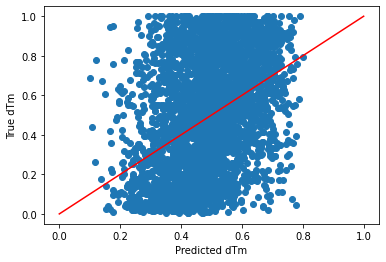

In [35]:
import matplotlib.pyplot as plt

np.random.seed(19680801)


fig, ax = plt.subplots()
plt.scatter(oof_df.pred_target, oof_df.target)
plt.xlabel('Predicted dTm')
plt.ylabel('True dTm')
plt.plot([0,1],'r')


plt.show()

In [36]:
CFG.path = OUTPUT_DIR
CFG.config_path = CFG.path+'config.pth'

In [37]:
class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts1 = df['sequence'].values
        self.texts2 = df['mutant_seq'].values
        self.position = df['position'].values

    def __len__(self):
        return len(self.texts1)

    def __getitem__(self, item):
        inputs1 = prepare_input(self.cfg, self.texts1[item])
        inputs2 = prepare_input(self.cfg, self.texts2[item])
        position = np.zeros(self.cfg.max_len)
        position[self.position[item]] = 1
        position = torch.tensor(position, dtype=torch.int)
        return inputs1, inputs2, position

In [38]:
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for (inputs1,inputs2, position) in tk0:
        for k, v in inputs1.items():
            inputs1[k] = v.to(device)
        for k, v in inputs2.items():
            inputs2[k] = v.to(device)
        position = position.to(device)
        with torch.no_grad():
            y_preds = model(inputs1,inputs2,position)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [39]:
# LOAD TEST WILDTYPE
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
len(base)

221

In [40]:
def get_test_mutation(row):
    for i,(a,b) in enumerate(zip(row.protein_sequence,base)):
        if a!=b: break
    row['wildtype'] = base[i]
    row['mutation'] = row.protein_sequence[i]
    row['position'] = i+1
    return row

In [ ]:
submission = pd.read_csv('/content/drive/Shareddrives/Erdos Team Pine/Kaggle Dataset - Functioning Code/input/sample_submission.csv')
test = ho_nlp
test = test.apply(get_test_mutation,axis=1)
deletions = test.loc[test.protein_sequence.str.len()==220,'seq_id'].values
test['sequence'] = base
test.sequence = test.sequence.map(add_spaces)
test = test.rename({'protein_sequence':'mutant_seq'},axis=1)
test.mutant_seq = test.mutant_seq.map(add_spaces)
print('Test data shape:', test.shape )
test.head()

AttributeError: ignored

In [41]:
test = ho_nlp
test_dataset = TestDataset(CFG, test)
test_loader = DataLoader(test_dataset,
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         #collate_fn=DataCollatorWithPadding(tokenizer=CFG.tokenizer, padding='longest'),
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
predictions_ = []
for fold in CFG.trn_fold:
    model = CustomModel(CFG, config_path=CFG.config_path, pretrained=False)
    state = torch.load(CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader, model, device)
    predictions_.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions_, axis=0)

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

In [42]:
print(predictions)

[[0.30432135]
 [0.41954997]
 [0.5749978 ]
 [0.62603676]
 [0.5129822 ]
 [0.44500592]
 [0.49364704]
 [0.32836527]
 [0.4497142 ]
 [0.3846594 ]
 [0.5927768 ]
 [0.5084444 ]
 [0.5486345 ]
 [0.6246042 ]
 [0.56718564]
 [0.5530783 ]
 [0.5661388 ]
 [0.43532968]
 [0.53927976]
 [0.4913391 ]
 [0.52006835]
 [0.49308556]
 [0.3096879 ]
 [0.49230063]
 [0.24217816]
 [0.24693984]
 [0.3769759 ]
 [0.36619675]
 [0.4340514 ]
 [0.44235152]
 [0.43083662]
 [0.50315255]
 [0.66008216]
 [0.31330395]
 [0.37624997]
 [0.49497366]
 [0.5594459 ]
 [0.5608268 ]
 [0.5566336 ]
 [0.5502949 ]
 [0.5329044 ]
 [0.54139245]
 [0.45618796]
 [0.48907512]
 [0.4489944 ]
 [0.46462086]
 [0.43441603]
 [0.44082764]
 [0.5081859 ]
 [0.6191703 ]
 [0.6171409 ]
 [0.49741712]
 [0.52915436]
 [0.351931  ]
 [0.30530858]
 [0.37086412]
 [0.34350088]
 [0.42955524]
 [0.30559576]
 [0.279768  ]
 [0.5894737 ]
 [0.5086005 ]
 [0.50475967]
 [0.5900179 ]
 [0.53415936]
 [0.6056875 ]
 [0.22724359]
 [0.36586896]
 [0.2459249 ]
 [0.22980931]
 [0.41926473]
 [0.28

In [54]:
ho_nlp['pred'] = predictions

In [ ]:
rs = []
for p in ho_nlp.PDB.unique():
    tmp = ho_nlp.loc[ho_nlp.PDB==p]
    
    target = 'dTm'
    if tmp.dTm.isna().sum()>len(tmp)/2: 
      target = 'ddG'
    
    r = mean_squared_error(tmp['pred'], tmp[target], squared=False)
    #r = np.abs( spearmanr( tmp.target, tmp.pred ).correlation )
    print(p,'ct=',len(tmp),'r=',r )
    rs.append(r)
print('==> CV',np.mean(rs))

In [ ]:
rs = []
for p in ho_nlp.PDB.unique():
    tmp = ho_nlp.loc[ho_nlp.PDB==p]
    
    target = 'dTm'
    if tmp.dTm.isna().sum()>len(tmp)/2: 
      target = 'ddG'
    
    #r = mean_squared_error(tmp['pred'], tmp[target], squared=False)
    r = np.abs( spearmanr( tmp.target, tmp.pred ).correlation )
    print(p,'ct=',len(tmp),'r=',r )
    rs.append(r)
print('==> CV',np.mean(rs))